In [21]:
%load_ext autoreload
import trafpy
import trafpy.generator as tpg
import os
import json

# load demand data
# DATA_NAME = 'ndf50_mldat6e8_university'
DATA_NAME = 'university_chancap500_numchans1_mldat2e6_bidirectional'
path_to_benchmark_data = os.path.dirname(trafpy.__file__)+'/../data/benchmark_data/{}_benchmark_data_v3.json'.format(DATA_NAME)
benchmark_data = json.loads(tpg.load_data_from_json(path_to_benchmark_data))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Time to load data from /home/zciccwf/phd_project/projects/trafpy/trafpy/../data/benchmark_data/university_chancap500_numchans1_mldat2e6_bidirectional_benchmark_data_v3.json: 1.1476750373840332 s


In [22]:
%autoreload

# organise into list of demand_data dicts
benchmarks = list(benchmark_data.keys())
demand_data_list = []
loads = []
for benchmark in benchmarks:
    for load in benchmark_data[benchmark]:
        for repeat in benchmark_data[benchmark][load]:
            demand_data = benchmark_data[benchmark][load][repeat]
            demand_data_list.append(demand_data)
            loads.append(load)
num_sets_of_demand_data = len(demand_data_list)
print('Number of sets of demand data: {}'.format(num_sets_of_demand_data))

Number of sets of demand data: 9


+----+--------+---------+-------+-------------+-------------+-------------+----------+------------+-------------+
|    | Name   |   Flows |   1st |        Last |    Duration |        Info |     Load |   Smallest |     Largest |
|----+--------+---------+-------+-------------+-------------+-------------+----------+------------+-------------|
|  0 | demand |   24000 |     0 | 2.82704e+06 | 2.82704e+06 | 8.47696e+08 |  599.705 |          1 | 2.83756e+07 |
|  1 | demand |   48000 |     0 | 2.5793e+06  | 2.5793e+06  | 1.54668e+09 | 1199.3   |          1 | 1.62287e+07 |
|  2 | demand |   96000 |     0 | 2.96908e+06 | 2.96908e+06 | 2.67115e+09 | 1799.31  |          1 | 9.41773e+06 |
|  3 | demand |   96000 |     0 | 2.46415e+06 | 2.46415e+06 | 2.9542e+09  | 2397.75  |          1 | 1.15951e+07 |
|  4 | demand |  192000 |     0 | 3.41763e+06 | 3.41763e+06 | 5.07995e+09 | 2972.79  |          1 | 1.02742e+07 |
|  5 | demand |   96000 |     0 | 2.23402e+06 | 2.23402e+06 | 3.98291e+09 | 3565.68  |  

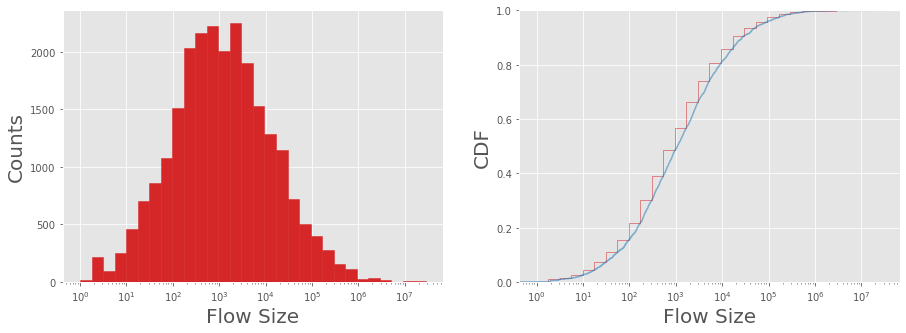

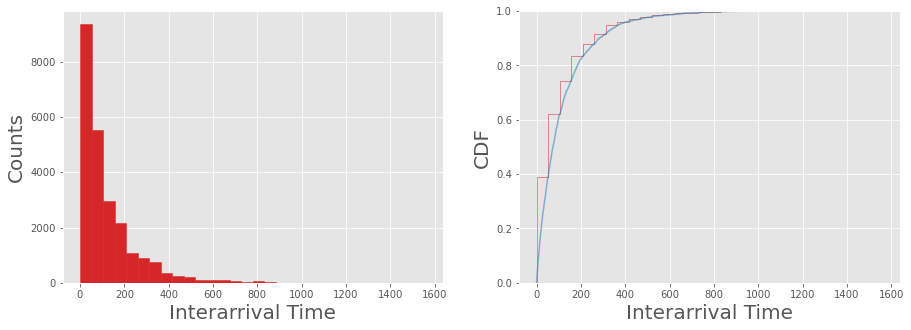

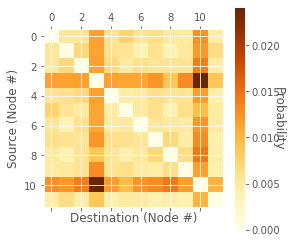

<Figure size 432x288 with 0 Axes>

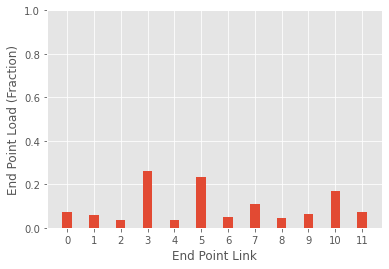

<Figure size 432x288 with 0 Axes>

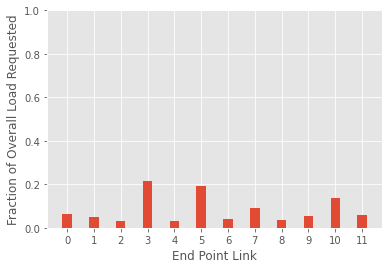

<Figure size 432x288 with 0 Axes>

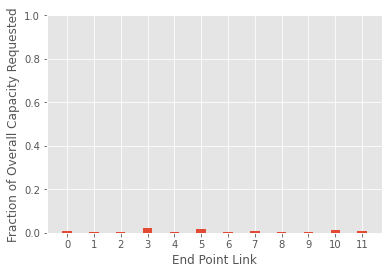

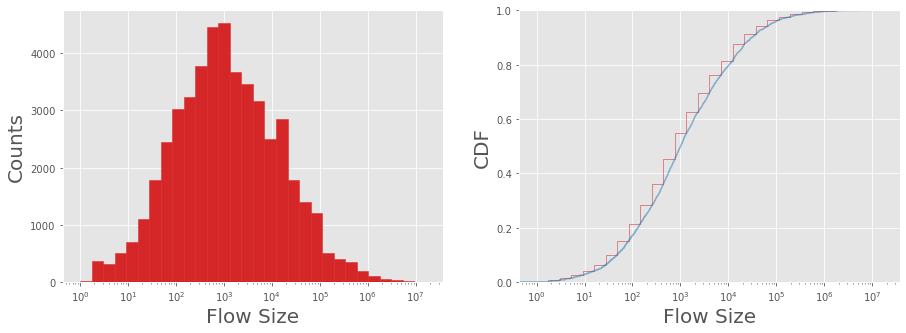

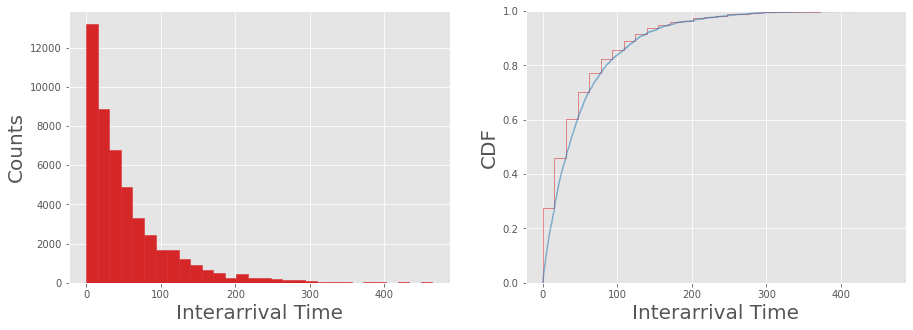

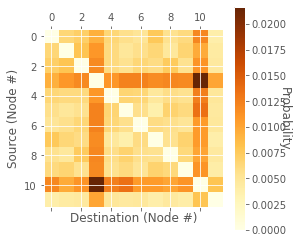

<Figure size 432x288 with 0 Axes>

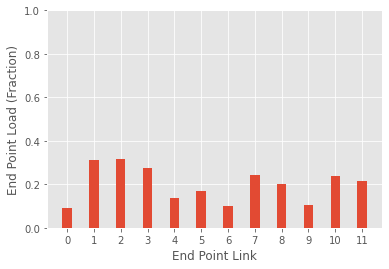

<Figure size 432x288 with 0 Axes>

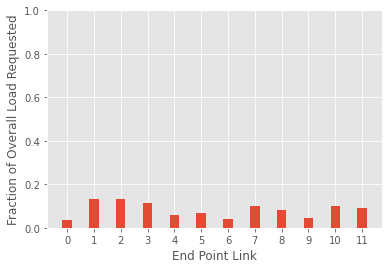

<Figure size 432x288 with 0 Axes>

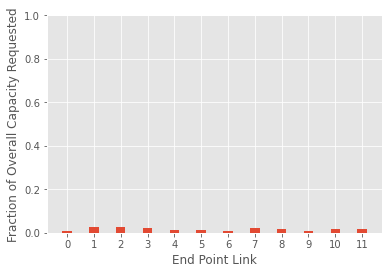

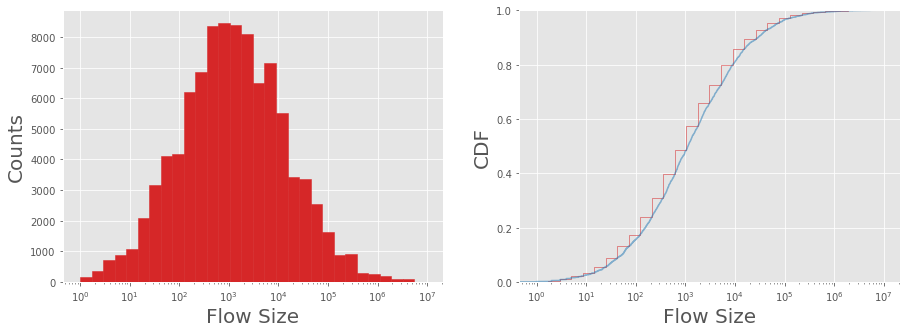

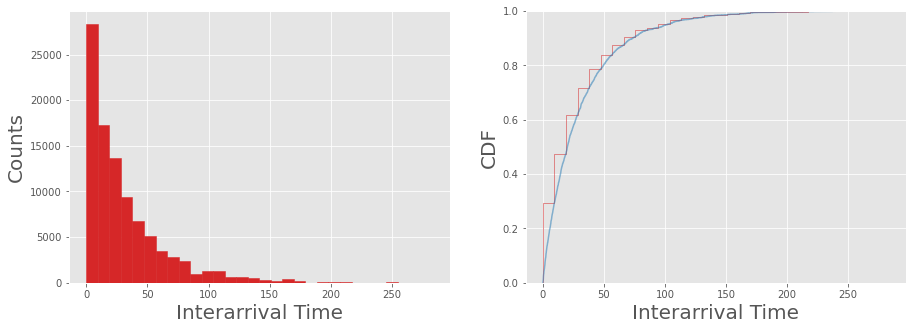

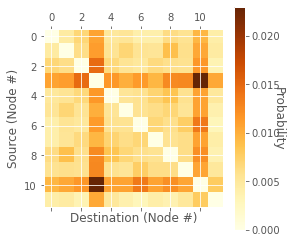

<Figure size 432x288 with 0 Axes>

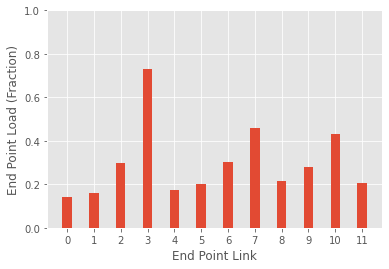

<Figure size 432x288 with 0 Axes>

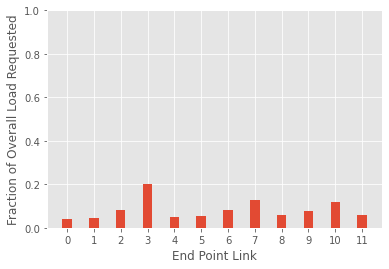

<Figure size 432x288 with 0 Axes>

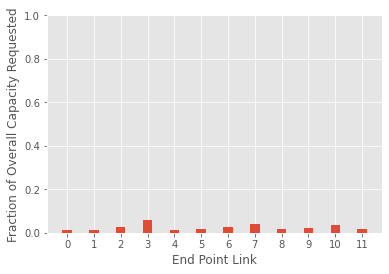

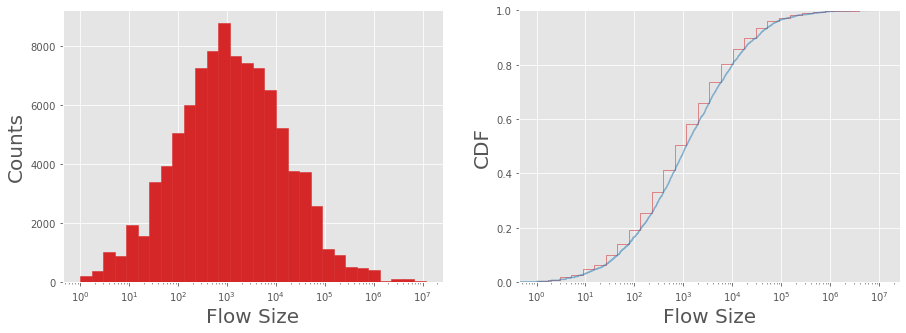

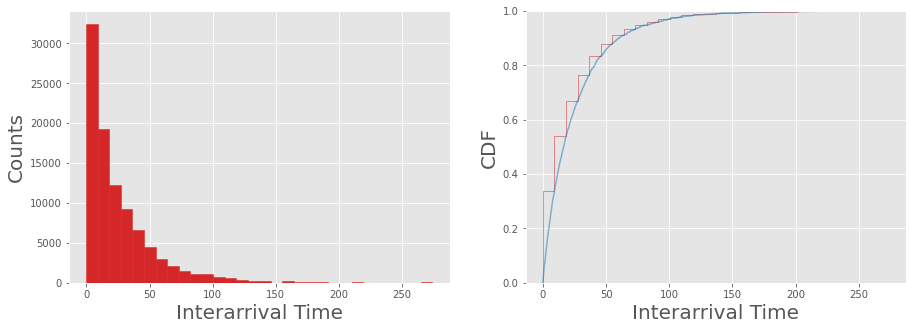

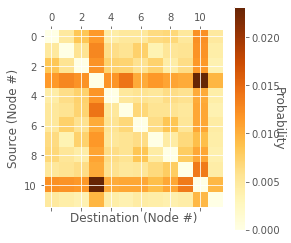

<Figure size 432x288 with 0 Axes>

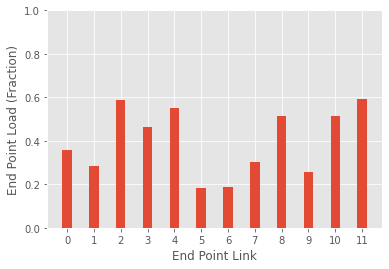

<Figure size 432x288 with 0 Axes>

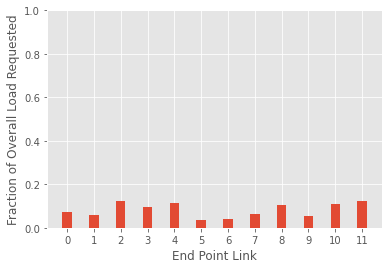

<Figure size 432x288 with 0 Axes>

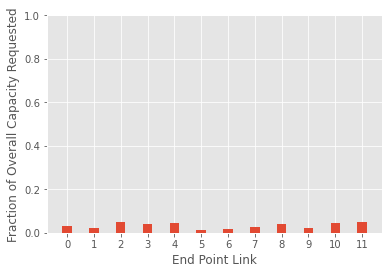

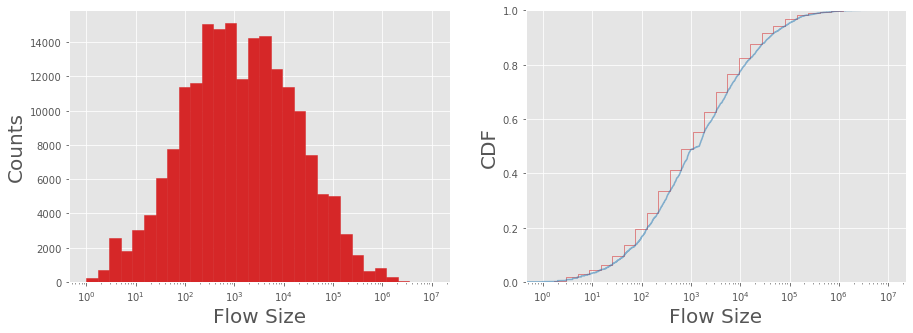

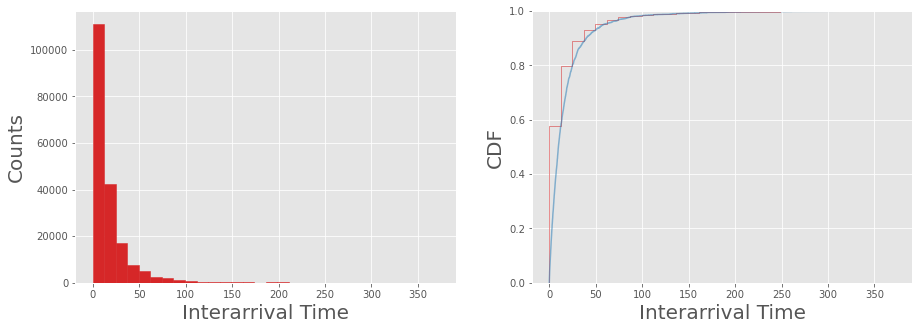

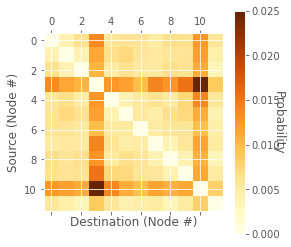

<Figure size 432x288 with 0 Axes>

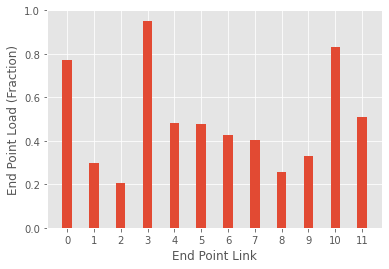

<Figure size 432x288 with 0 Axes>

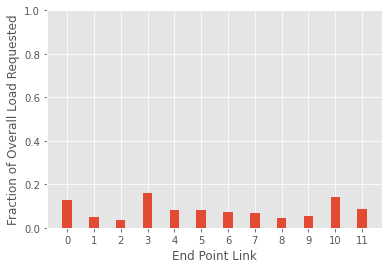

<Figure size 432x288 with 0 Axes>

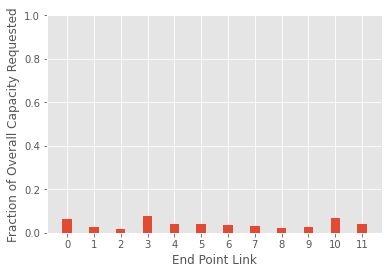

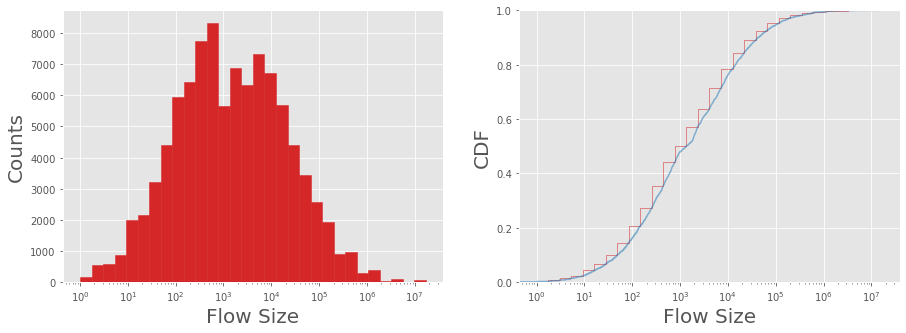

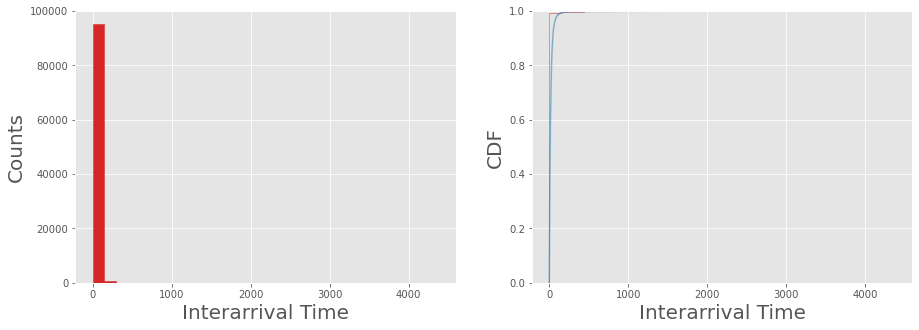

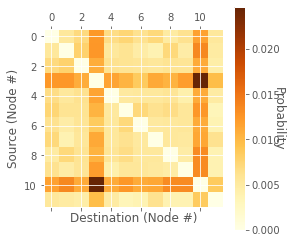

<Figure size 432x288 with 0 Axes>

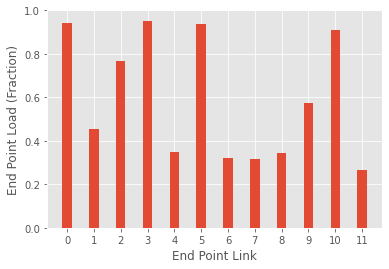

<Figure size 432x288 with 0 Axes>

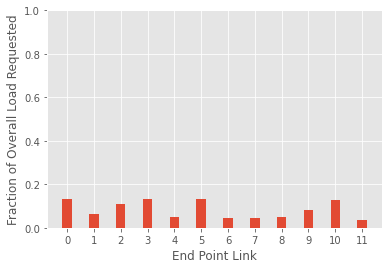

<Figure size 432x288 with 0 Axes>

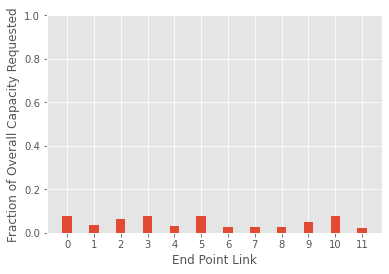

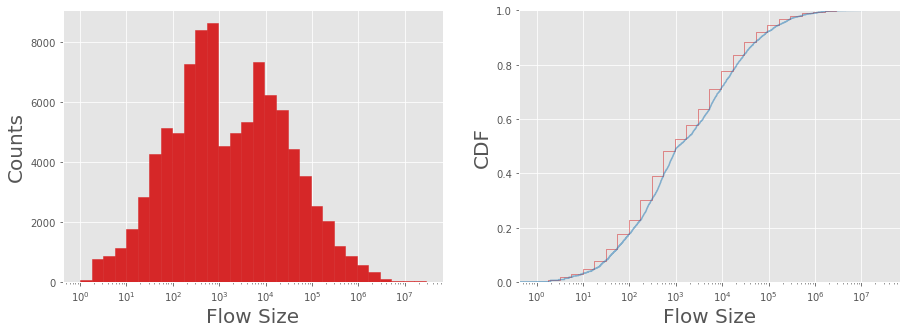

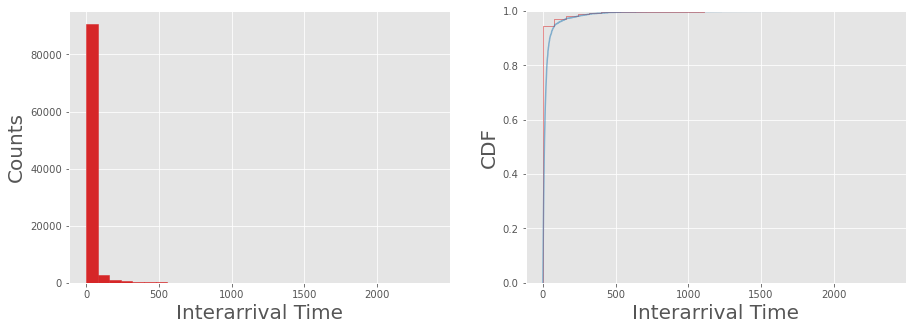

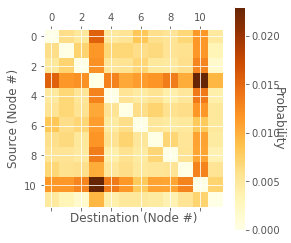

<Figure size 432x288 with 0 Axes>

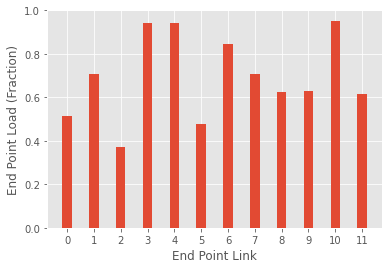

<Figure size 432x288 with 0 Axes>

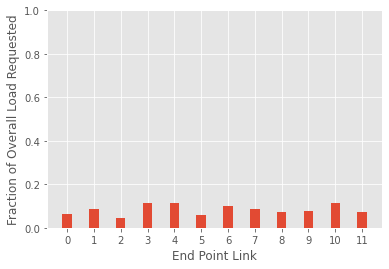

<Figure size 432x288 with 0 Axes>

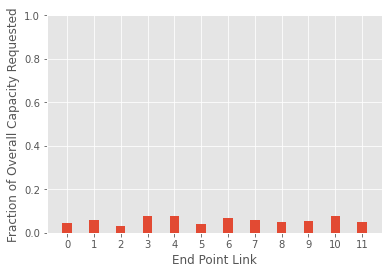

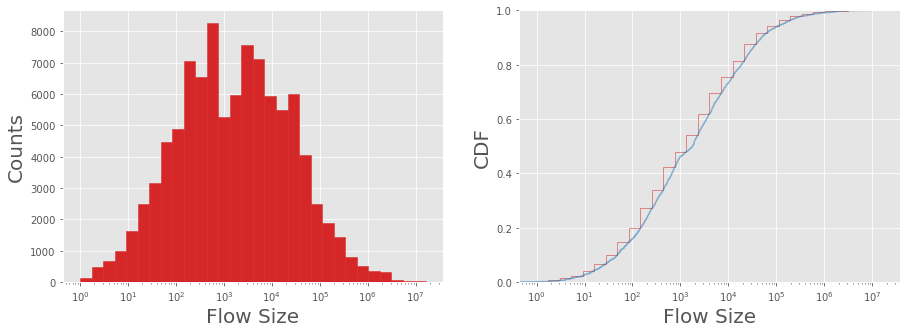

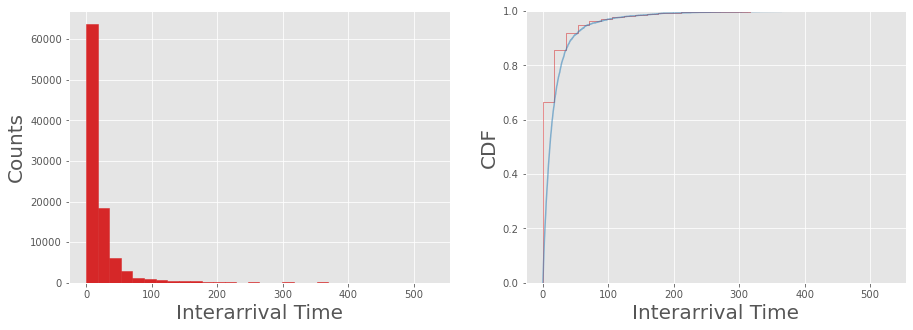

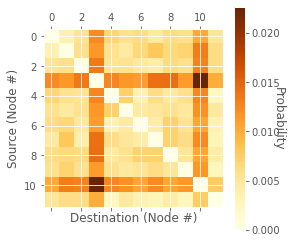

<Figure size 432x288 with 0 Axes>

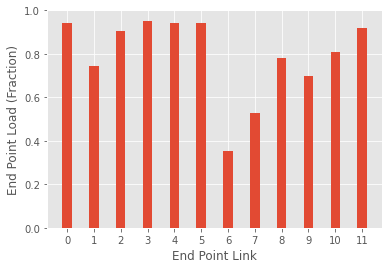

<Figure size 432x288 with 0 Axes>

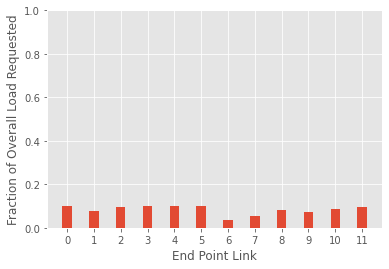

<Figure size 432x288 with 0 Axes>

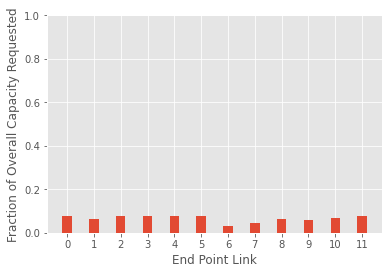

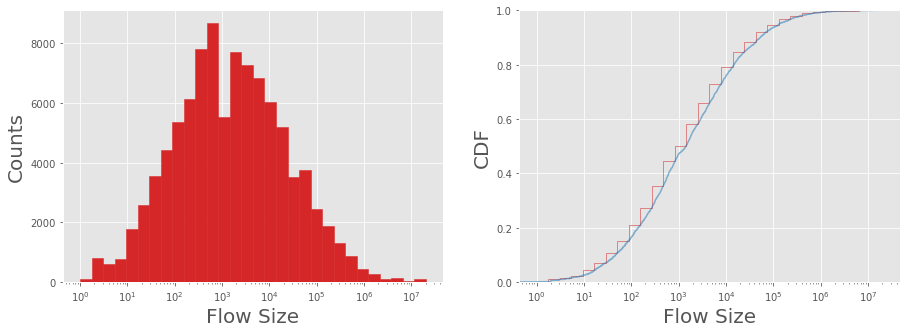

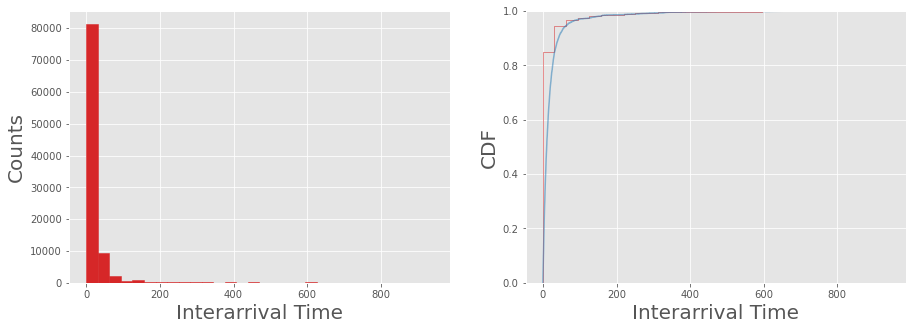

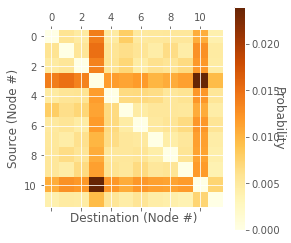

<Figure size 432x288 with 0 Axes>

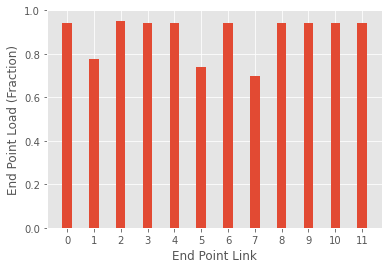

<Figure size 432x288 with 0 Axes>

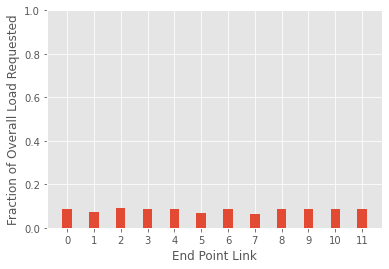

<Figure size 432x288 with 0 Axes>

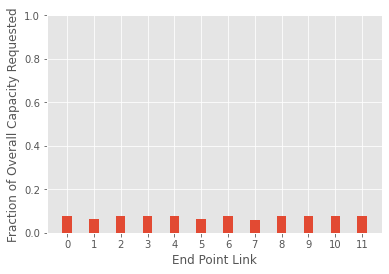

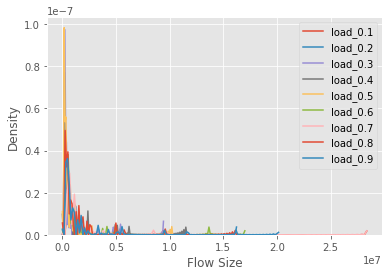

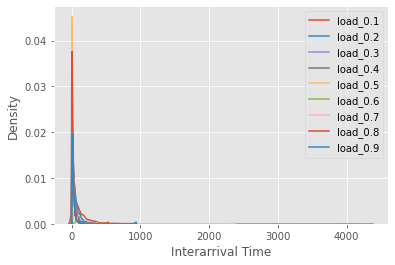

In [23]:
%autoreload
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0}) # disable warnings
from trafpy.generator import Demand, DemandsAnalyser, DemandPlotter, DemandsPlotter

# for plotting
net = tpg.gen_fat_tree(k=3, N=2, num_channels=1, server_to_rack_channel_capacity=500, rack_to_edge_channel_capacity=40000, edge_to_agg_channel_capacity=40000, agg_to_core_channel_capacity=40000)
slot_size = 1e6

# create demand objects and print analysis summary
demands = []
for demand_data, load in zip(demand_data_list, loads):
    demand = Demand(demand_data, net.graph['endpoints'])
    demand.name = 'load_{}'.format(load) # name for multi-plot legend(s)
    demands.append(demand)
    plotter = DemandPlotter(demand)
    plotter.plot_flow_size_dist(logscale=True, num_bins=30)
    plotter.plot_interarrival_time_dist(logscale=False, num_bins=30)
    plotter.plot_node_dist(eps=['server_{}'.format(i) for i in range(12)])
    plotter.plot_node_load_dists(eps=['server_{}'.format(i) for i in range(12)], ep_link_bandwidth=500)
#     plotter.plot_link_loads_vs_time(net, slot_size, demand, mean_period='all')
analyser = DemandsAnalyser(*demands)
analyser.compute_metrics(print_summary=True)

plotters = DemandsPlotter(*demands)
_ = plotters.plot_flow_size_dists(logscale=False)
_ = plotters.plot_interarrival_time_dists(logscale=False)

In [ ]:
_ = plotters.plot_link_loads_vs_time_for_different_loads(logscale=False)

In [10]:
%autoreload
print('Keys of first demand data set:\n{}'.format(demand_data_list[0].keys()))
# print('\nStructure of first demand data set:\n{}'.format(demand_data_list[0]))

Keys of first demand data set:
dict_keys(['flow_id', 'sn', 'dn', 'flow_size', 'event_time', 'establish', 'index'])


In [11]:
%autoreload
for benchmark in benchmarks:
    print(benchmark_data[benchmark].keys())
    for load in list(benchmark_data[benchmark].keys()):
        for repeat in benchmark_data[benchmark][load]:
            print('benchmark: {} | load: {} | repeat: {}'.format(benchmark,load,repeat))

dict_keys(['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0'])
benchmark: university | load: 0.1 | repeat: 0
benchmark: university | load: 0.2 | repeat: 0
benchmark: university | load: 0.3 | repeat: 0
benchmark: university | load: 0.4 | repeat: 0
benchmark: university | load: 0.5 | repeat: 0
benchmark: university | load: 0.6 | repeat: 0
benchmark: university | load: 0.7 | repeat: 0
benchmark: university | load: 0.8 | repeat: 0
benchmark: university | load: 0.9 | repeat: 0
benchmark: university | load: 1.0 | repeat: 0


In [12]:
%autoreload
from trafpy.generator import Demand
import sys
import json

demand = Demand(demand_data_list[-1])
for SLOT_SIZE in [1e4]:
    slots_dict = demand.get_slots_dict(SLOT_SIZE, print_info=True)

Generated slot dict in 28.2989 s with slot size 10000.0 and total session time 2388622.6468607676 for 384000 demands.
Approx memory size of slot dict: 193165557 Bytes
Number of slots making up total session time: 239
Number of these slots in which no new demands arrived: 0
Fraction of the 239 total time slots from simulation start to finish in which no new demands arrive: 0.0
Average number of demands arriving per time slot: 1606.695
Number of keys in updated slot dict (after removing empty slots where no new demands arrived): 239

Notice: In simulation, the scheduler makes a decision at every time slot. Therefore the more time slots there are, the more processing overhead there is, and therefore the longer the simulation will take. If many of your slot sizes are redundant (i.e. no new flow information is arriving), it is advisable to increase the slot size -> decrease the number of slots -> decrease the number steps in the simulation -> decrease the simulation time. Conversely, if you

In [13]:
slots_dict[0]

{'lb_time': 0.0,
 'ub_time': 10000.0,
 'new_event_dicts': [{'flow_id': 'flow_0',
   'size': 349.0,
   'src': 'server_5',
   'dst': 'server_0',
   'establish': 1,
   'parent_deps': None,
   'completed_parent_deps': [],
   'child_deps': None,
   'parent_op_run_time': None,
   'time_parent_op_started': None,
   'parent_op': None,
   'dependency_type': None,
   'child_op': None,
   'can_schedule': 1,
   'job_id': None,
   'path': None,
   'channel': None,
   'packets': None,
   'packet_size': None,
   'packets_this_slot': 0,
   'time_arrived': 0.0,
   'time_completed': None,
   'k_shortest_paths': None},
  {'flow_id': 'flow_1',
   'size': 469.0,
   'src': 'server_9',
   'dst': 'server_1',
   'establish': 1,
   'parent_deps': None,
   'completed_parent_deps': [],
   'child_deps': None,
   'parent_op_run_time': None,
   'time_parent_op_started': None,
   'parent_op': None,
   'dependency_type': None,
   'child_op': None,
   'can_schedule': 1,
   'job_id': None,
   'path': None,
   'channel':